# Natural Langauge Processing: Sentiment Analysis

----

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from re import sub
from sklearn.model_selection import train_test_split

# Getting the stopwords dataset from the NLTK Corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
ignored_words = set(stopwords.words('English'))
ignored_words.remove('not')

# Transforms strings into numerical tokens.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to C:\Users\Dinesh
[nltk_data]     Balakrishnan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


----

### Preprocessing

In [2]:
# Getting the dataset and creating X,y
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)
X = []
y = dataset['Liked']

# Preprocessing the reviews.
for review in dataset.index:
    review = dataset['Review'][review].lower()
    review = sub('[^a-z]', ' ', review)

    review = review.split()
    review = [word for word in review if not word in ignored_words]
    review = ' '.join(review)
    
    X.append(review)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

----

### Text Tokenization

In [3]:
max_words = 500
oov_token = '<OOV>'
padding_type = 'post'
trunc_type = 'post'
max_len = 10
embedding_dim = 8

# Creating the Word Index
tokenizer = Tokenizer(num_words = max_words, oov_token = oov_token)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Converting X_train and X_test to vectors.
X_train, X_test = tokenizer.texts_to_sequences(X_train), tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, padding = padding_type, truncating = trunc_type, maxlen = max_len)
X_test = pad_sequences(X_test, padding = padding_type, truncating = trunc_type, maxlen = max_len)

# Converting y_train and y_test to vectors.
y_train, y_test = np.expand_dims(y_train, axis = 1), np.expand_dims(y_test, axis = 1)

----

### Creating the Model

_Note:_ **Embedding()** creates higher dimensional vectors to represent individual words. The main purpose of this is to allow similar words to have similar vectors and classification. **GlobalAveragePooling1D()** then averages the vectors created by the data input into the **Embedding()** to create a single output vector. An alternative approach would be to use a **Flatten()** layer and manually specify the resulting dimensions of the output vector. 

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding((len(word_index) + 1), embedding_dim, input_length = max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

----

### Viewing Model Details

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 8)             13744     
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 13,785
Trainable params: 13,785
Non-trainable params: 0
_________________________________________________________________


----

### Training the Neural Network & Testing

In [6]:
results =  model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 15, verbose = 2)

Train on 850 samples, validate on 150 samples
Epoch 1/15
850/850 - 1s - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6923 - val_accuracy: 0.5200
Epoch 2/15
850/850 - 0s - loss: 0.6909 - accuracy: 0.6435 - val_loss: 0.6910 - val_accuracy: 0.6133
Epoch 3/15
850/850 - 0s - loss: 0.6879 - accuracy: 0.6871 - val_loss: 0.6889 - val_accuracy: 0.6067
Epoch 4/15
850/850 - 0s - loss: 0.6835 - accuracy: 0.7247 - val_loss: 0.6858 - val_accuracy: 0.6533
Epoch 5/15
850/850 - 0s - loss: 0.6775 - accuracy: 0.7812 - val_loss: 0.6820 - val_accuracy: 0.6800
Epoch 6/15
850/850 - 0s - loss: 0.6688 - accuracy: 0.8176 - val_loss: 0.6765 - val_accuracy: 0.6800
Epoch 7/15
850/850 - 0s - loss: 0.6574 - accuracy: 0.8329 - val_loss: 0.6694 - val_accuracy: 0.6933
Epoch 8/15
850/850 - 0s - loss: 0.6429 - accuracy: 0.8541 - val_loss: 0.6602 - val_accuracy: 0.6933
Epoch 9/15
850/850 - 0s - loss: 0.6252 - accuracy: 0.8412 - val_loss: 0.6490 - val_accuracy: 0.7000
Epoch 10/15
850/850 - 0s - loss: 0.6037 - accuracy: 0.

----

### Graphing Accuracy & Loss

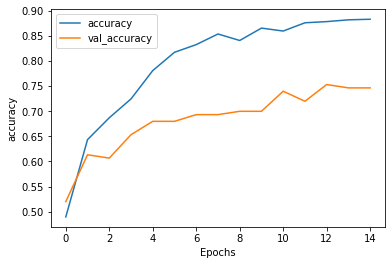

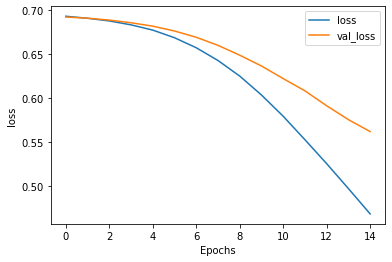

In [7]:
def plot_graphs(history, string):
    plt.plot(history[string])
    plt.plot(history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(results.history, "accuracy")
plot_graphs(results.history, "loss")

----

### Visualizing Word Embeddings

_Note:_ Vector and metadata files need to be imported into https://projector.tensorflow.org/ to visualize textual relationship. The below code simply creates these files.

In [8]:
import io

token_index = dict([(value, key) for (key, value) in word_index.items()])
weights = model.layers[0].get_weights()[0]

vectors = io.open('vecs.tsv', 'w', encoding = 'utf-8')
metadata = io.open('meta.tsv', 'w', encoding = 'utf-8')

for word_count in range(1, len(word_index)):
    word = token_index[word_count]
    embeddings = weights[word_count]
    vectors.write('\t'.join([str(value) for value in embeddings]) + '\n')
    metadata.write(word + '\n')
    
vectors.close()
metadata.close()
